# Machine Learning Models

In [ ]:
pip install full-fred

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import itertools
from full_fred.fred import Fred
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree
from sklearn import feature_selection
from scipy.linalg import LinAlgWarning
from scipy.spatial import distance
from keras import Sequential
from keras.layers import Dense
import tensorflow as tf

In [ ]:
fred = Fred('drive/MyDrive/Machine Learning Project/key.txt') # key.txt contains a valid FRED API key

In [ ]:
pd.set_option('max_colwidth', 400)

Import all of the data from Google Drive.

In [ ]:
df = pd.read_csv('drive/MyDrive/Machine Learning Project/data/AllData.csv')

for i in range(len(df['date'])):
  df.loc[i, 'date'] = datetime.strptime(df['date'][i].split()[0], '%Y-%m-%d')

print(df.head())

                  date   AAA   BAA  ...  PCU22112222112243  UNRATE  UNRATECHG
0  1960-01-01 00:00:00  4.61  5.34  ...               17.6     5.2          0
1  1960-02-01 00:00:00  4.56  5.34  ...               17.8     4.8          0
2  1960-03-01 00:00:00  4.49  5.25  ...               17.8     5.4          1
3  1960-04-01 00:00:00  4.45  5.20  ...               17.8     5.2          0
4  1960-05-01 00:00:00  4.46  5.28  ...               17.8     5.1          0

[5 rows x 803 columns]


Examine the output variables.

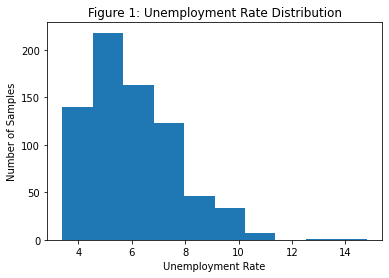

In [ ]:
plt.hist(df['UNRATE'].values)
plt.xlabel('Unemployment Rate')
plt.ylabel('Number of Samples')
plt.title('Figure 1: Unemployment Rate Distribution')
plt.show()

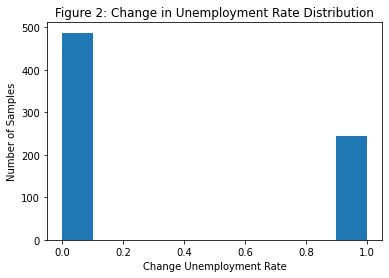

In [ ]:
plt.hist(df['UNRATECHG'].values)
plt.xlabel('Change Unemployment Rate')
plt.ylabel('Number of Samples')
plt.title('Figure 2: Change in Unemployment Rate Distribution')
plt.show()

Create training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, df['UNRATE'], test_size = 0.2, random_state = 1)

In [ ]:
X_train_chg, X_test_chg, y_train_chg, y_test_chg = train_test_split(features, df['UNRATECHG'], test_size = 0.2, random_state = 1)

Scale the data.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = features.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns = features.columns, index = X_test.index)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_chg)
X_train_chg = pd.DataFrame(scaler.transform(X_train_chg), columns = features.columns, index = X_train_chg.index)
X_test_chg = pd.DataFrame(scaler.transform(X_test_chg), columns = features.columns, index = X_test_chg.index)

## Regression Models

In [ ]:
def mse(y_true, y_pred):
  mse = 0
  for i in range(len(y_pred)):
    mse = mse + (y_pred[i] - y_true[i])**2
  return mse / len(y_pred)

In [ ]:
def evaluate_reg_model(reg_model, X_test, y_test):
  y_pred = reg_model.predict(X_test)
  return mse(y_test.values, y_pred)

### Linear Regression

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print(reg)

LinearRegression()


### Ridge Regression (with 10-fold cross-validation for alpha)

In [ ]:
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = LinAlgWarning, module = 'sklearn')

ridge_reg = RidgeCV(alphas = np.arange(0, 1, 0.01), cv = 10, scoring = 'neg_mean_squared_error')
ridge_reg.fit(X_train, y_train)

print(ridge_reg.alpha_)

0.01


### KNN Regression (with 10-fold cross-validation for n_neighbors)

In [ ]:
param_distribs = {'n_neighbors': [int(x) for x in np.linspace(1, 10, num = 10)]}

rand_search = RandomizedSearchCV(KNeighborsRegressor(), param_distribs, cv = 10, scoring = 'neg_mean_squared_error')
rand_search.fit(X_train, y_train)

knn_reg = rand_search.best_estimator_
knn_reg.fit(X_train, y_train)

print(knn_reg)

KNeighborsRegressor(n_neighbors=1)


### Random Forest

In [ ]:
random_forest_reg = RandomForestRegressor(random_state = 1)
random_forest_reg.fit(X_train, y_train)

print(random_forest_reg)

RandomForestRegressor(random_state=1)


### Neural Network

In [ ]:
def build_model_reg(n_layers, n_neurons):
  model = Sequential()
  model.add(Dense(n_neurons, input_dim = X_train.shape[1], activation = 'relu'))
  for n in range(n_layers - 1):
    model.add(Dense(n_neurons, activation = 'relu'))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [tf.keras.metrics.MeanSquaredError()])
  return model

In [ ]:
n_layers_all = [1, 2, 3]
n_neurons_all = [10, 20, 30, 40, 50]
min_mse, n_layers_best, n_neurons_best = 10000, 0, 0
for n_layers in n_layers_all:
  for n_neurons in n_neurons_all:
    nn_model = build_model_reg(n_layers, n_neurons)
    train_history = nn_model.fit(X_train, y_train, validation_split = 0.1, batch_size = 5, epochs = 50, verbose = 0)
    mse = train_history.history['val_mean_squared_error'][-1]
    print(n_layers, n_neurons, mse)
    if mse < min_mse:
      min_mse = mse
      n_layers_best = n_layers
      n_neurons_best = n_neurons

1 10 0.12378288060426712
1 20 0.23277129232883453
1 30 0.2544398307800293
1 40 0.11201243847608566
1 50 0.28732430934906006
2 10 0.08431235700845718
2 20 0.17014668881893158
2 30 0.14390571415424347
2 40 0.07703378796577454
2 50 0.12527304887771606
3 10 0.09488704800605774
3 20 0.18055136501789093
3 30 0.06237717717885971
3 40 0.10089162737131119
3 50 0.23073381185531616


In [ ]:
print(n_layers_best, n_neurons_best)
nn_model_reg = build_model_reg(n_layers_best, n_neurons_best)
nn_model_reg.fit(X_train, y_train, validation_split = 0.1, batch_size = 5, epochs = 50, verbose = 0)

3 30


In [ ]:
mse(y_test.values, np.concatenate(nn_model_reg.predict(X_test)))

0.0691158519181851

## Regression Results

In [ ]:
results_df = pd.DataFrame(columns = ['Model', 'MSE'])
results_df['Model'] = ['Linear Regression', 'Ridge Regression', 'KNN', 'Random Forest', 'Neural Network']
results_df['MSE'] = [evaluate_reg_model(reg, X_test, y_test), evaluate_reg_model(ridge_reg, X_test, y_test), 
                     evaluate_reg_model(knn_reg, X_test, y_test), evaluate_reg_model(random_forest_reg, X_test, y_test),
                     mse(y_test.values, np.concatenate(nn_model_reg.predict(X_test)))]
print('Table 1: Regression Results')
results_df

Table 1: Regression Results


,Model,MSE
0,Linear Regression,0.285064
1,Ridge Regression,0.040110
2,KNN,0.104490
3,Random Forest,0.079080
4,Neural Network,0.069116


## Regression Feature Importance

### Ridge Regression

In [ ]:
reg_coefs = ridge_reg.coef_
reg_importance = abs(reg_coefs) > np.quantile(abs(reg_coefs), 0.99)
importance_df = pd.DataFrame(columns = ['Series ID', 'Series Name', 'Importance'])
ids, names, importances = [], [], []
for i in range(len(reg_importance)):
  if reg_importance[i] == True:
    series_id = features.columns[i]
    ids.append(series_id)
    names.append(fred.get_a_series(series_id)['seriess'][0]['title'])
    importances.append(reg_coefs[i])
importance_df['Series ID'], importance_df['Series Name'], importance_df['Importance'] = ids, names, importances
importance_df = importance_df.sort_values(by = 'Importance', key = abs, ascending = False)

In [ ]:
print('Table 3: Ridge Regression Feature Importance')
importance_df

Table 3: Ridge Regression Feature Importance


,Series ID,Series Name,Importance
4,CWUR0000SA0R,Consumer Price Index for All Urban Wage Earners and Clerical Workers: Purchasing Power of the Consumer Dollar in U.S. City Average,-1.727205
3,CUUR0000SA0R,Consumer Price Index for All Urban Consumers: Purchasing Power of the Consumer Dollar in U.S. City Average,-1.691057
6,WPU1597,Producer Price Index by Commodity: Miscellaneous Products: Brooms and Brushes,-1.545716
0,DDURRG3M086SBEA,Personal consumption expenditures: Durable goods (chain-type price index),-1.277709
5,WPU125,Producer Price Index by Commodity: Furniture and Household Durables: Home Electronic Equipment,1.267154
2,CWSR0000SAD,Consumer Price Index for All Urban Wage Earners and Clerical Workers: Durables in U.S. City Average,1.262876
1,MVGFD027MNFRBDAL,Market Value of Gross Federal Debt,1.259814
7,PCU311422311422,Producer Price Index by Industry: Specialty Canning,1.253810


In [ ]:
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = LinAlgWarning, module = 'sklearn')

X_train_import = X_train.filter(items = importance_df['Series ID'])
X_test_import = X_test.filter(items = importance_df['Series ID'])

ridge_reg_import = RidgeCV(alphas = np.arange(0, 1, 0.01), cv = 10, scoring = 'neg_mean_squared_error')
ridge_reg_import.fit(X_train_import, y_train)

print(ridge_reg_import.alpha_)
print(mse(y_test.values, ridge_reg_import.predict(X_test_import)))

0.0
1.6357483870768803


### Random Forest

In [ ]:
random_forest_scores = random_forest_reg.feature_importances_
random_forest_reg_importance = abs(random_forest_scores) > np.quantile(abs(random_forest_scores), 0.99)
importance_df = pd.DataFrame(columns = ['Series ID', 'Series Name', 'Importance'])
ids, names, importances = [], [], []
for i in range(len(random_forest_reg_importance)):
  if random_forest_reg_importance[i] == True:
    series_id = features.columns[i]
    ids.append(series_id)
    names.append(fred.get_a_series(series_id)['seriess'][0]['title'])
    importances.append(reg_coefs[i])
importance_df['Series ID'], importance_df['Series Name'], importance_df['Importance'] = ids, names, importances
importance_df = importance_df.sort_values(by = 'Importance', key = abs, ascending = False)

In [ ]:
print('Table 4: Random Forest (Regression) Feature Importance')
importance_df

Table 4: Random Forest (Regression) Feature Importance


,Series ID,Series Name,Importance
5,CES3000000034,"Indexes of Aggregate Weekly Hours of Production and Nonsupervisory Employees, Manufacturing",0.744695
2,CES0600000034,"Indexes of Aggregate Weekly Hours of Production and Nonsupervisory Employees, Goods-Producing",0.733757
3,CES1021000001,"All Employees, Mining",0.211996
6,CEU3100000001,"All Employees, Durable Goods",-0.150672
4,USMINE,"All Employees, Mining and Logging",0.129658
1,BAAFFM,Moody's Seasoned Baa Corporate Bond Minus Federal Funds Rate,0.049083
7,HOUST,New Privately-Owned Housing Units Started: Total Units,-0.018861
0,AAA,Moody's Seasoned Aaa Corporate Bond Yield,0.004836


In [ ]:
X_train_import = X_train.filter(items = importance_df['Series ID'])
X_test_import = X_test.filter(items = importance_df['Series ID'])

random_forest_reg_import = RandomForestRegressor(random_state = 1)
random_forest_reg_import.fit(X_train_import, y_train)

print(random_forest_reg_import)
print(mse(y_test.values, random_forest_reg_import.predict(X_test_import)))

RandomForestRegressor(random_state=1)
0.06924724489795904


## Classification Models

In [ ]:
def eval_class(class_model, X_test, y_test):
  y_pred = class_model.predict(X_test)
  return accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_test, y_pred):
  acc = accuracy_score(y_test, pred)
  prec = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  return [acc, prec, recall, f1]

### Decision Tree (with 10-fold cross-validation for criterion, max_depth, max_leaf_nodes)

In [ ]:
max_depth = [int(x) for x in range(1, 10)]
max_depth.append(None)
max_leaf_nodes = [int(x) for x in range(2, 10)]
max_leaf_nodes.append(None)
param_distribs = {'criterion': ['gini', 'entropy'],'max_depth': max_depth, 'max_leaf_nodes': max_leaf_nodes}

rand_search = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_distribs, cv = 10)
rand_search.fit(X_train_chg, y_train_chg)

decision_tree = rand_search.best_estimator_
decision_tree.fit(X_train_chg, y_train_chg)

print(decision_tree)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=2)


Figure 3: Decision Tree


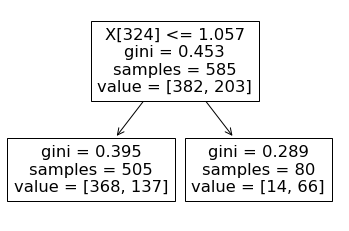

In [ ]:
print('Figure 3: Decision Tree')
tree_plot = tree.plot_tree(decision_tree)
plt.show()

In [ ]:
# recession indicator (binary)
# if 0, predict that unemployment rate decreases
# if 1, predict that unemployment rate increases
features.columns[324] # USRECM

'USRECM'

### Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter = 500)
log_reg.fit(X_train_chg, y_train_chg)

print(log_reg)

LogisticRegression(max_iter=500)


### KNN Classification (with 10-fold cross-validation for n_neighbors, metric)

In [ ]:
param_distribs = {'n_neighbors': [int(x) for x in np.linspace(1, 20, num = 20)], 'metric': [distance.euclidean, distance.minkowski, distance.cosine]}

rand_search = RandomizedSearchCV(KNeighborsClassifier(), param_distribs, cv = 10)
rand_search.fit(X_train_chg, y_train_chg)

knn = rand_search.best_estimator_
knn.fit(X_train_chg, y_train_chg)

print(knn)

KNeighborsClassifier(metric=<function euclidean at 0x7f35f1c468c0>,
                     n_neighbors=15)


### Random Forest

In [ ]:
random_forest = RandomForestClassifier(random_state = 1)
random_forest.fit(X_train_chg, y_train_chg)

print(random_forest)

RandomForestClassifier(random_state=1)


### Neural Networks

In [ ]:
def build_model_class(n_layers, n_neurons):
  model = Sequential()
  model.add(Dense(n_neurons, input_dim = X_train.shape[1], activation = 'relu'))
  for n in range(n_layers - 1):
    model.add(Dense(n_neurons, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

In [ ]:
n_layers_all = [1, 2, 3]
n_neurons_all = [10, 20, 30, 40, 50]
max_val_accuracy, n_layers_best, n_neurons_best = 0, 0, 0
for n_layers in n_layers_all:
  for n_neurons in n_neurons_all:
    nn_model = build_model_class(n_layers, n_neurons)
    train_history = nn_model.fit(X_train_chg, y_train_chg, validation_split = 0.1, batch_size = 5, epochs = 50, verbose = 0)
    val_accuracy = train_history.history['val_accuracy'][-1]
    print(n_layers, n_neurons, val_accuracy)
    if val_accuracy > max_val_accuracy:
      max_val_accuracy = val_accuracy
      n_layers_best = n_layers
      n_neurons_best = n_neurons

1 10 0.6440678238868713
1 20 0.6271186470985413
1 30 0.6101694703102112
1 40 0.6610169410705566
1 50 0.694915235042572
2 10 0.6610169410705566
2 20 0.6610169410705566
2 30 0.6610169410705566
2 40 0.6610169410705566
2 50 0.694915235042572
3 10 0.6610169410705566
3 20 0.6779661178588867
3 30 0.5423728823661804
3 40 0.6440678238868713
3 50 0.6101694703102112


In [ ]:
print(n_layers_best, n_neurons_best)
nn_model = build_model_class(n_layers_best, n_neurons_best)
train_history = nn_model.fit(X_train_chg, y_train_chg, validation_split = 0.1, batch_size = 5, epochs = 50, verbose = 0)

1 50


In [ ]:
accuracy_score(y_test_chg, nn_model.predict(X_test_chg) > 0.5)

0.7074829931972789

## Classification Results

In [ ]:
models = ['Decision Tree', 'Logistic Regression', 'KNN', 'Random Forest', 'Neural Network']

methods = pd.DataFrame()
methods['Methods'] = models

metrics = []
for model in [decision_tree, log_reg, knn, random_forest, nn_model]:
  if model == nn_model:
    pred = np.concatenate(model.predict(X_test_chg) >= 0.5).astype(int)
  else:
    pred = model.predict(X_test)
  metrics.append(evaluate_model(y_test_chg, pred))
metrics = pd.DataFrame(np.row_stack(metrics), columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score'])
metrics['Methods'] = models

evaluation = pd.merge(methods, metrics, on = 'Methods')
print('Table 2: Classification Results')
evaluation

Table 2: Classification Results


,Methods,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.768707,0.666667,0.380952,0.484848
1,Logistic Regression,0.707483,0.486486,0.428571,0.455696
2,KNN,0.727891,0.555556,0.238095,0.333333
3,Random Forest,0.687075,0.437500,0.333333,0.378378
4,Neural Network,0.707483,0.488889,0.523810,0.505747


## Classification Feature Importance

### Logistic Regression

In [ ]:
reg_coefs = log_reg.coef_[0]
reg_importance = abs(reg_coefs) > np.quantile(abs(reg_coefs), 0.99)
importance_df = pd.DataFrame(columns = ['Series ID', 'Series Name', 'Importance'])
ids, names, importances = [], [], []
for i in range(len(reg_importance)):
  if reg_importance[i] == True:
    series_id = features.columns[i]
    ids.append(series_id)
    names.append(fred.get_a_series(series_id)['seriess'][0]['title'])
    importances.append(reg_coefs[i])
importance_df['Series ID'], importance_df['Series Name'], importance_df['Importance'] = ids, names, importances
importance_df = importance_df.sort_values(by = 'Importance', key = abs, ascending = False)

In [ ]:
print('Table 5: Logistic Regression Feature Importance')
importance_df

Table 5: Logistic Regression Feature Importance


,Series ID,Series Name,Importance
2,CES0600000007,"Average Weekly Hours of Production and Nonsupervisory Employees, Goods-Producing",1.004804
5,DPCERGM1M225SBEA,Prices for Personal Consumption Expenditures: Chained Price Index,-0.967929
0,BAA10YM,Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity,-0.872860
7,WPU0113,Producer Price Index by Commodity: Farm Products: Fresh and Dry Vegetables,-0.865740
3,CEU3000000009,"Average Weekly Overtime Hours of Production and Nonsupervisory Employees, Manufacturing",-0.772361
6,DSERRGM1M225SBEA,Prices for Personal Consumption Expenditures: Chained Price Index: Services,0.737637
1,NONREVSLAR,Percent Change of Total Nonrevolving Consumer Credit,0.727584
4,DGDSRGM1M225SBEA,Prices for Personal Consumption Expenditures: Chained Price Index: Goods,0.677677


In [ ]:
X_train_chg_import = X_train_chg.filter(items = importance_df['Series ID'])
X_test_chg_import = X_test_chg.filter(items = importance_df['Series ID'])

log_reg_import = LogisticRegression()
log_reg_import.fit(X_train_chg_import, y_train_chg)

print(log_reg_import)
print(evaluate_model(y_test_chg.values, ridge_reg_import.predict(X_test_chg_import)))

LogisticRegression()
[0.7074829931972789, 0.4888888888888889, 0.5238095238095238, 0.5057471264367817]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- BAA10YM
- CES0600000007
- CEU3000000009
- DGDSRGM1M225SBEA
- DPCERGM1M225SBEA
- ...
Feature names seen at fit time, yet now missing:
- CUUR0000SA0R
- CWSR0000SAD
- CWUR0000SA0R
- DDURRG3M086SBEA
- MVGFD027MNFRBDAL
- ...

  warnings.warn(message, FutureWarning)


### Random Forest

In [ ]:
random_forest_scores = random_forest.feature_importances_
random_forest_importance = abs(random_forest_scores) > np.quantile(abs(random_forest_scores), 0.99)
importance_df = pd.DataFrame(columns = ['Series ID', 'Series Name', 'Importance'])
ids, names, importances = [], [], []
for i in range(len(random_forest_importance)):
  if random_forest_importance[i] == True:
    series_id = features.columns[i]
    ids.append(series_id)
    names.append(fred.get_a_series(series_id)['seriess'][0]['title'])
    importances.append(reg_coefs[i])
importance_df['Series ID'], importance_df['Series Name'], importance_df['Importance'] = ids, names, importances
importance_df = importance_df.sort_values(by = 'Importance', key = abs, ascending = False)

In [ ]:
print('Table 6: Random Forest (Classification) Feature Importance')
importance_df

Table 6: Random Forest (Classification) Feature Importance


,Series ID,Series Name,Importance
6,USRECM,NBER based Recession Indicators for the United States from the Peak through the Trough,0.661386
2,USREC,NBER based Recession Indicators for the United States from the Period following the Peak through the Trough,0.213447
3,USRECD,NBER based Recession Indicators for the United States from the Period following the Peak through the Trough,0.213447
5,USRECDP,NBER based Recession Indicators for the United States from the Peak through the Period preceding the Trough,-0.111532
7,USRECP,NBER based Recession Indicators for the United States from the Peak through the Period preceding the Trough,-0.111532
1,FLNONREVSLA,"Nonrevolving Consumer Credit Owned and Securitized, Flow",0.033500
4,USRECDM,NBER based Recession Indicators for the United States from the Peak through the Trough,-0.013230
0,TB6SMFFM,6-Month Treasury Bill Minus Federal Funds Rate,-0.008370


In [ ]:
X_train_chg_import = X_train_chg.filter(items = importance_df['Series ID'])
X_test_chg_import = X_test_chg.filter(items = importance_df['Series ID'])

random_forest_import = RandomForestClassifier()
random_forest_import.fit(X_train_chg_import, y_train_chg)

print(random_forest_import)
print(evaluate_model(y_test_chg.values, random_forest_import.predict(X_test_chg_import)))

RandomForestClassifier()
[0.7074829931972789, 0.4888888888888889, 0.5238095238095238, 0.5057471264367817]
